# Tarea 2: Comparación de modelos

### Marcelino Sánchez Rodríguez
### 6 de marzo de 2023

In [2]:
# Load necessary packages
library(rstan)
library(coda)
library(R2jags)
library(methods)

# set the working directory

setwd("/home/rstudio/tarea2RegAvanz")

#--- Funciones utiles ---
prob<-function(x){
  out<-min(length(x[x>0])/length(x),length(x[x<0])/length(x))
  out
}

source("/home/rstudio/tarea2RegAvanz/claseNietor6.R")


Loading required package: StanHeaders

Loading required package: ggplot2

rstan (Version 2.21.8, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)


Attaching package: ‘coda’


The following object is masked from ‘package:rstan’:

    traceplot


Loading required package: rjags

Linked to JAGS 4.3.0

Loaded modules: basemod,bugs


Attaching package: ‘R2jags’


The following object is masked from ‘package:coda’:

    traceplot


The following object is masked from ‘package:rstan’:

    traceplot




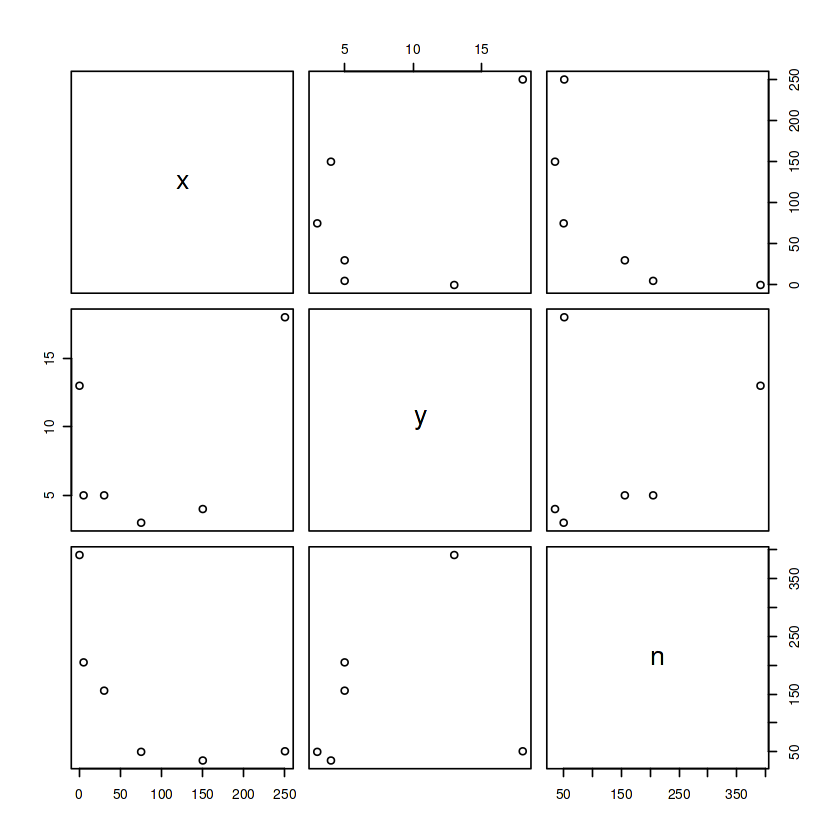

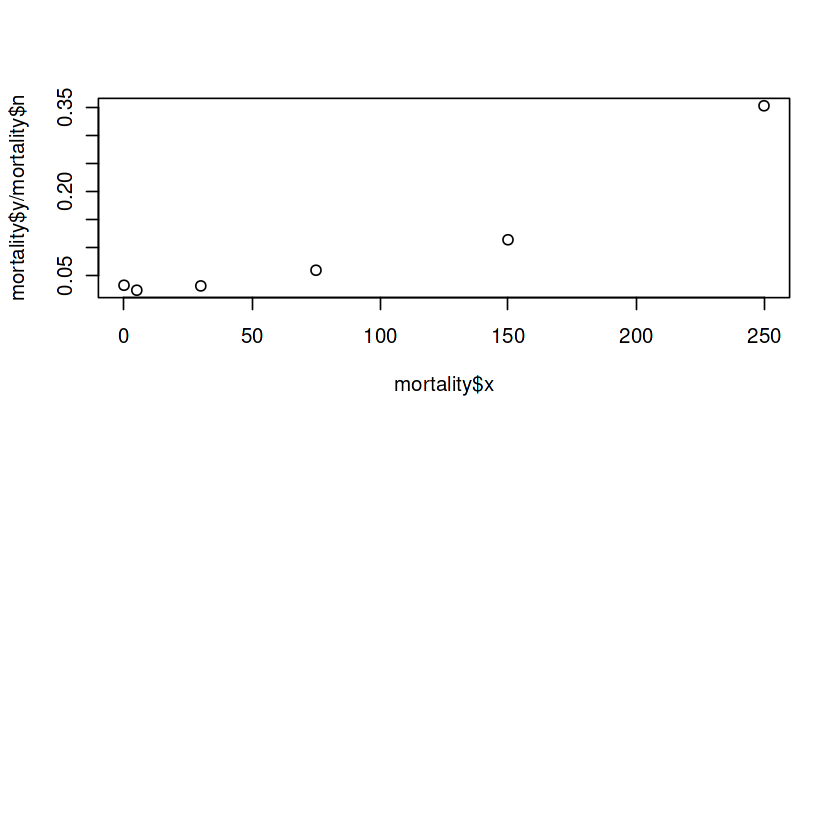

In [3]:
mortality<-read.table("http://gente.itam.mx/lnieto/index_archivos/mortality.txt",header=TRUE)
n<-nrow(mortality)

#creamos gráficas de los datos de mortalidad
par(mfrow = c(2, 1))
plot(mortality)
plot(mortality$x,mortality$y/mortality$n)
m<-1
nef<-c(100)
xf<-c(200)

In [4]:
#-Defining data-
data<-list("n"=n,"ne"=mortality$n,"y"=mortality$y,"x"=mortality$x,"m"=m,"nef"=nef,"xf"=xf)
data2<-list("n"=n,"y"=mortality$y/mortality$n,"x"=mortality$x,"m"=m,"xf"=xf)

#-Defining inits-
inits<-function(){list(beta=rep(0,2),yf1=rep(1,n),yf2=1)}
inits2<-function(){list(beta=rep(0,2),phy=1,yf1=rep(1,n),yf2=1)}

#-Selecting parameters to monitor-
parsa<-c("beta","lambda","yf1","yf2")
parsbc<-c("beta","p","yf1","yf2")
parsd<-c("beta","phy","yf1","yf2")

## Primer modelo

Modelo

$y_{i}|\mu_{i} \sim \text{Poisson}(\mu_{i})$

Relación

$\mu_{i}=\text{n}_{i}\lambda_{i}$

Liga

$\text{log}(\lambda_{i})=\beta_{1}+\beta_{2}*x_{i}$

Priors

$\beta_{j} \sim \text{Norm}(0,0.001)$

In [5]:
#corremos código


modelCode1 <- 'model
{
#Likelihood
for (i in 1:n) {
	y[i] ~ dpois(mu[i])
	mu[i]<-ne[i]*lambda[i]
	log(lambda[i])<-beta[1]+beta[2]*x[i]
	}
#Priors 
for (j in 1:2) { beta[j] ~ dnorm(0,0.001) }
#Prediction 1
for (i in 1:n) { yf1[i] ~ dpois(mu[i]) }
#Prediction 2
#for (i in 1:m) { 
#	yf2[i] ~ dpois(muf[i]) 
#	muf[i]<-nef[i]*lambdaf[i]
#	log(lambdaf[i])<-beta[1]+beta[2]*xf[i]
#}
	yf2 ~ dpois(muf) 
	muf<-nef*lambdaf
	log(lambdaf)<-beta[1]+beta[2]*xf

}'

ej5a.sim <- jagsModel$new(data, inits, parsa, modelCode1,n.thin=10, n.iter=50000, n.burnin=5000)

ej5a.sim$runJagsModel()

module glm loaded

Warning message in jags.model(model.file, data = data, inits = init.values, n.chains = n.chains, :
“Unused variable "m" in data”


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 6
   Unobserved stochastic nodes: 9
   Total graph size: 60

Initializing model



## Verificamos convergencia

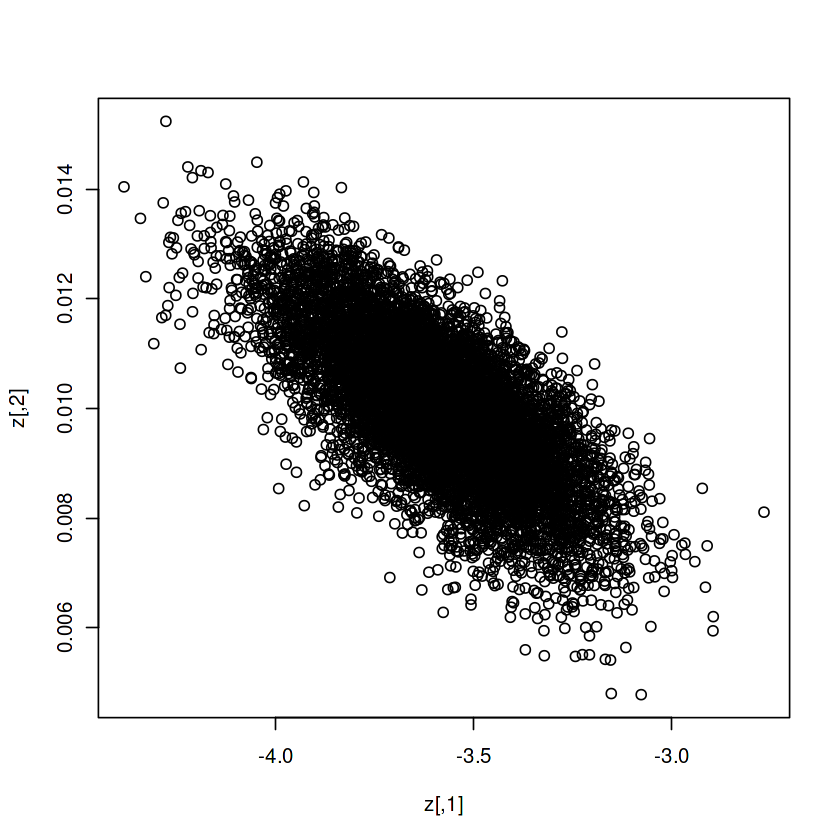

                 mean          sd         2.5%          25%         50%
beta[1]   -3.58778636 0.207251500 -4.001826571 -3.724804815 -3.58227856
beta[2]    0.01000486 0.001315380  0.007415224  0.009128652  0.01000840
deviance  25.12791765 2.022944019 23.169242469 23.696255052 24.50771349
lambda[1]  0.02825344 0.005824579  0.018282215  0.024117807  0.02781225
lambda[2]  0.02967486 0.005979625  0.019385960  0.025421705  0.02923465
lambda[3]  0.03795364 0.006837560  0.025988911  0.033140447  0.03746434
lambda[4]  0.05926174 0.009035574  0.043006039  0.052965393  0.05874017
lambda[5]  0.12549665 0.019068490  0.091229891  0.112133253  0.12465214
lambda[6]  0.34638595 0.079459750  0.210129205  0.289189045  0.33959709
yf1[1]    11.04500000 4.059409560  4.000000000  8.000000000 11.00000000
yf1[2]     6.07677778 2.714023509  1.000000000  4.000000000  6.00000000
yf1[3]     5.97077778 2.691644675  1.000000000  4.000000000  6.00000000
yf1[4]     2.93322222 1.763392441  0.000000000  2.000000000  3.0

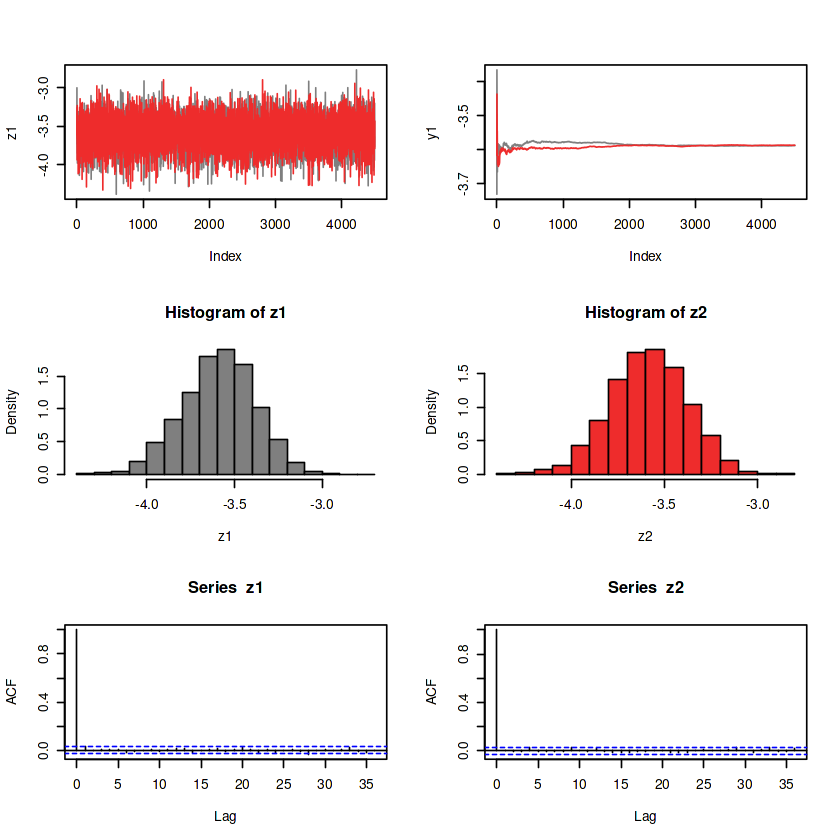

In [6]:
ej5a.sim$viewSpace()

ej5a.sim$graphConvergence()

ej5a.sim$summaryModel()

ej5a.sim$dicModelfunc()

## Checamos intervalos de predicción

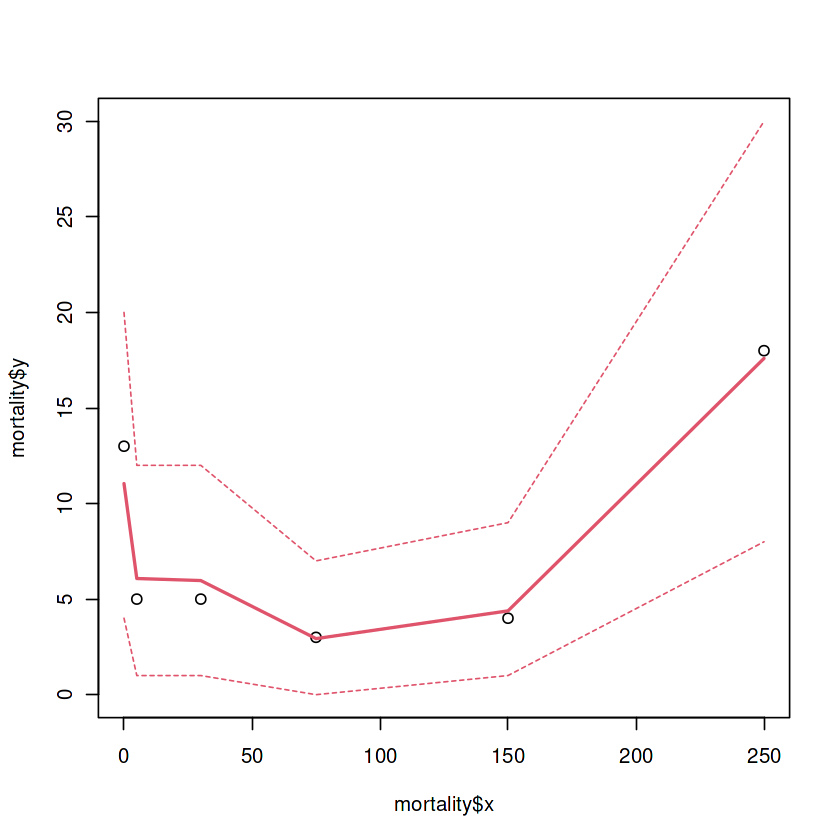

In [7]:
canvaMortalidad()

mortalidadGraf(ej5a.sim,col=2)

## Segundo modelo (logística)

Modelo

$y_{i}|\mu_{i} \sim \text{Bin}(\text{n}_{i},\text{p}_{i})$

Relación

$\mu_{i}=\text{n}_{i}\text{p}_{i}$

Liga logística

$\text{logit}(\text{p}_{i})=\beta_{1}+\beta_{2}*x_{i}$

Priors

$\beta_{j} \sim \text{Norm}(0,0.001)$

In [8]:
#corremos código
modelCode2 <- 'model
{
#Likelihood
for (i in 1:n) {
	y[i] ~ dbin(p[i],ne[i])
	mu[i]<-ne[i]*p[i]
#Liga logistica
	logit(p[i])<-beta[1]+beta[2]*x[i]
#	eta[i]<-beta[1]+beta[2]*x[i]
#	p[i]<-exp(eta[i])/(1+exp(eta[i]))
#Liga probit
#	p[i]<-phi(beta[1]+beta[2]*x[i])
#Liga log-log
#	eta[i]<-beta[1]+beta[2]*x[i]
#	p[i]<-exp(-exp(eta[i]))
#Liga clog-log
#	cloglog(p[i])<-beta[1]+beta[2]*x[i]
	}
#Priors 
for (j in 1:2) { beta[j] ~ dnorm(0,0.001) }
#Prediction 1
for (i in 1:n) { yf1[i] ~ dbin(p[i],ne[i]) }
#Prediction 2
#for (i in 1:m) { 
#	yf2[i] ~ dbin(pf[i],nef[i]) 
#	muf[i]<-nef[i]*pf[i]
#	logit(pf[i])<-beta[1]+beta[2]*xf[i]
#}
	yf2 ~ dbin(pf,nef) 
	muf<-nef*pf
#	logit(pf)<-beta[1]+beta[2]*xf
#	pf<-phi(beta[1]+beta[2]*xf)
#	etaf<-beta[1]+beta[2]*xf
#	pf<-exp(-exp(etaf))
	cloglog(pf)<-beta[1]+beta[2]*xf	
}'

ej5b.sim <- jagsModel$new(data, inits, parsbc, modelCode2, n.thin=10, n.iter=50000, n.burnin=5000)

ej5b.sim$runJagsModel()



Warning message in jags.model(model.file, data = data, inits = init.values, n.chains = n.chains, :
“Unused variable "m" in data”


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 6
   Unobserved stochastic nodes: 9
   Total graph size: 60

Initializing model



## Verificamos convergencia

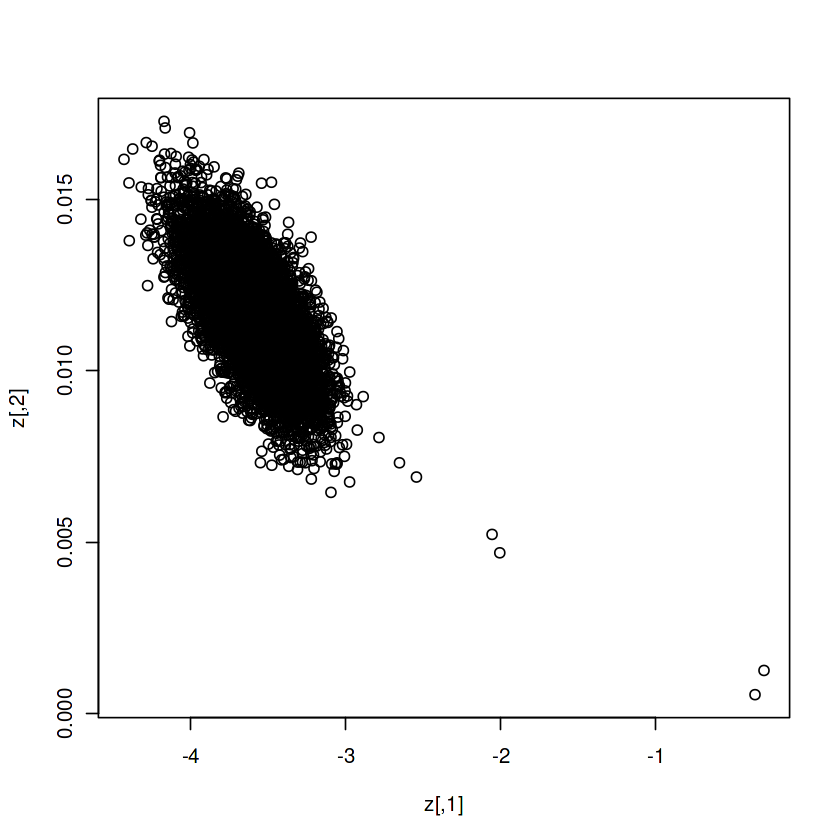

                mean           sd         2.5%         25%         50%
beta[1]  -3.59063362  0.219838361 -4.030129438 -3.73225720 -3.58396840
beta[2]   0.01166409  0.001496006  0.008791289  0.01067400  0.01167003
deviance 24.88968350 10.443438677 22.764495644 23.29912727 24.12502975
p[1]      0.02747922  0.008213470  0.017461700  0.02337907  0.02701521
p[2]      0.02904740  0.008332930  0.018708789  0.02482919  0.02859455
p[3]      0.03831519  0.009025911  0.026081341  0.03343784  0.03782601
p[4]      0.06277245  0.011068462  0.045554403  0.05597322  0.06225242
p[5]      0.13832368  0.021752609  0.100210652  0.12318432  0.13702730
p[6]      0.34022492  0.061658235  0.226012597  0.29627089  0.33806115
yf1[1]   10.69766667  4.588190184  4.000000000  8.00000000 10.00000000
yf1[2]    5.99288889  2.973295691  1.000000000  4.00000000  6.00000000
yf1[3]    6.00411111  2.788480740  2.000000000  4.00000000  6.00000000
yf1[4]    3.12555556  1.800597567  0.000000000  2.00000000  3.00000000
yf1[5]

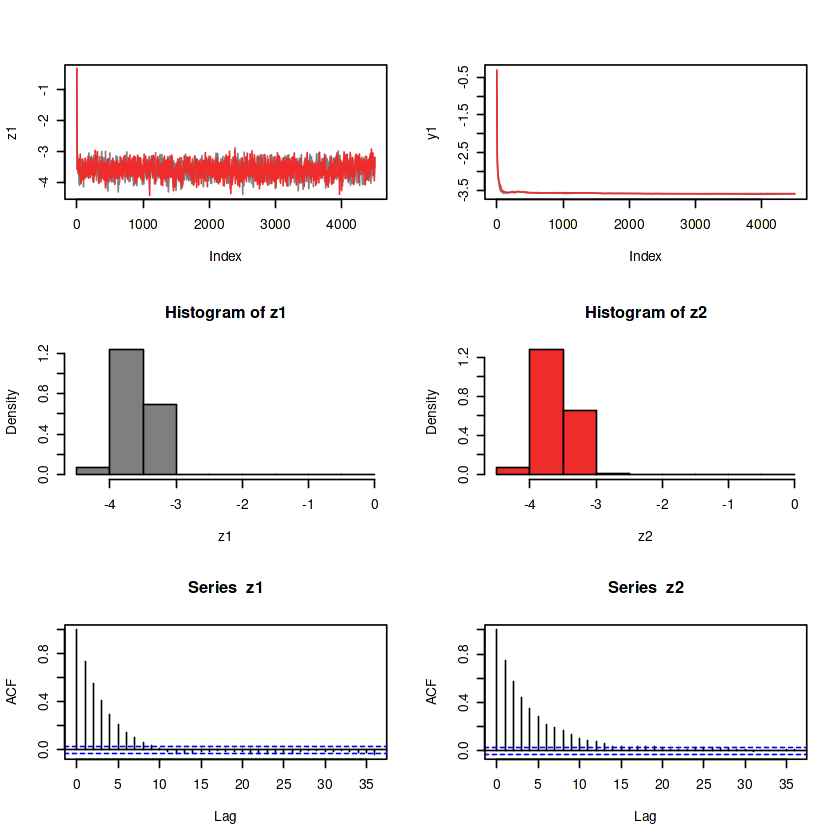

In [9]:
ej5b.sim$viewSpace()

ej5b.sim$graphConvergence()

ej5b.sim$summaryModel()

ej5b.sim$dicModelfunc()


## Checamos intervalos de predicción

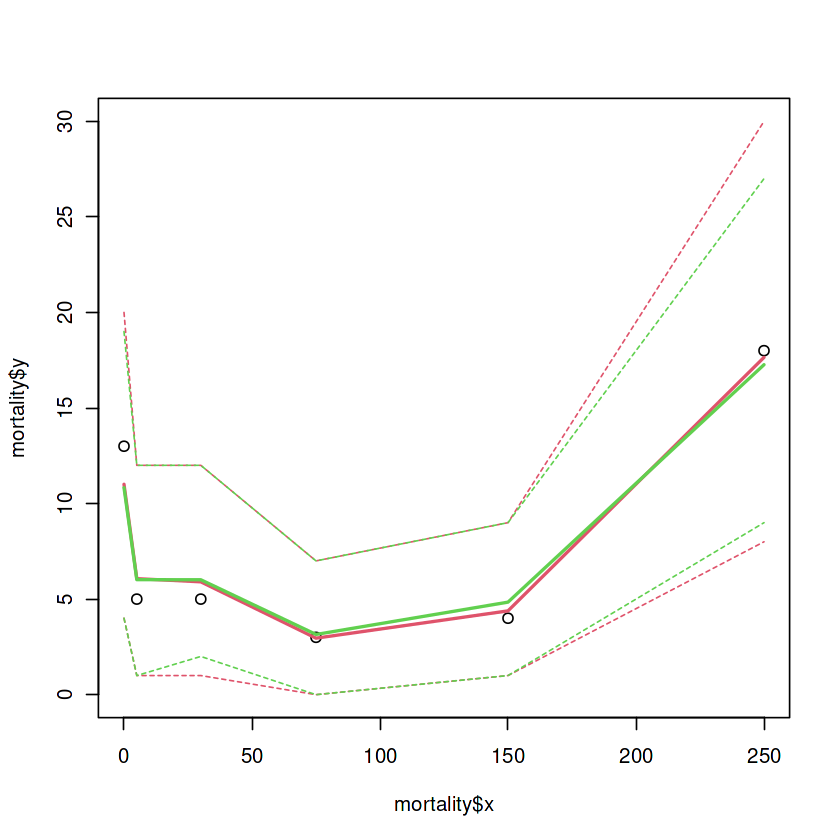

In [203]:
canvaMortalidad()

mortalidadGraf(ej5a.sim,col=2)

mortalidadGraf(ej5b.sim,col=3)

## Tercer modelo (probit)

CHECAR

Modelo

$y_{i}|\mu_{i} \sim \text{Bin}(\text{n}_{i},\text{p}_{i})$

Relación

$\mu_{i}=\text{n}_{i}\text{p}_{i}$

Liga logística

$\text{logit}(\text{p}_{i})=\beta_{1}+\beta_{2}*x_{i}$

Priors

$\beta_{j} \sim \text{Norm}(0,0.001)$

In [10]:
#corremos código
modelCode3 <- 'model
{
#Likelihood
for (i in 1:n) {
	y[i] ~ dbin(p[i],ne[i])
	mu[i]<-ne[i]*p[i]
#Liga logistica
#	logit(p[i])<-beta[1]+beta[2]*x[i]
#	eta[i]<-beta[1]+beta[2]*x[i]
#	p[i]<-exp(eta[i])/(1+exp(eta[i]))
#Liga probit
	p[i]<-phi(beta[1]+beta[2]*x[i])
#Liga log-log
#	eta[i]<-beta[1]+beta[2]*x[i]
#	p[i]<-exp(-exp(eta[i]))
#Liga clog-log
#	cloglog(p[i])<-beta[1]+beta[2]*x[i]
	}
#Priors 
for (j in 1:2) { beta[j] ~ dnorm(0,0.001) }
#Prediction 1
for (i in 1:n) { yf1[i] ~ dbin(p[i],ne[i]) }
#Prediction 2
#for (i in 1:m) { 
#	yf2[i] ~ dbin(pf[i],nef[i]) 
#	muf[i]<-nef[i]*pf[i]
#	logit(pf[i])<-beta[1]+beta[2]*xf[i]
#}
	yf2 ~ dbin(pf,nef) 
	muf<-nef*pf
#	logit(pf)<-beta[1]+beta[2]*xf
#	pf<-phi(beta[1]+beta[2]*xf)
#	etaf<-beta[1]+beta[2]*xf
#	pf<-exp(-exp(etaf))
	cloglog(pf)<-beta[1]+beta[2]*xf	
}'

ej5b.sim2 <- jagsModel$new(data, inits, parsbc, modelCode3, n.thin=5, n.iter=50000, n.burnin=5000)

ej5b.sim2$runJagsModel()

Warning message in jags.model(model.file, data = data, inits = init.values, n.chains = n.chains, :
“Unused variable "m" in data”


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 6
   Unobserved stochastic nodes: 9
   Total graph size: 60

Initializing model



## Verificamos convergencia

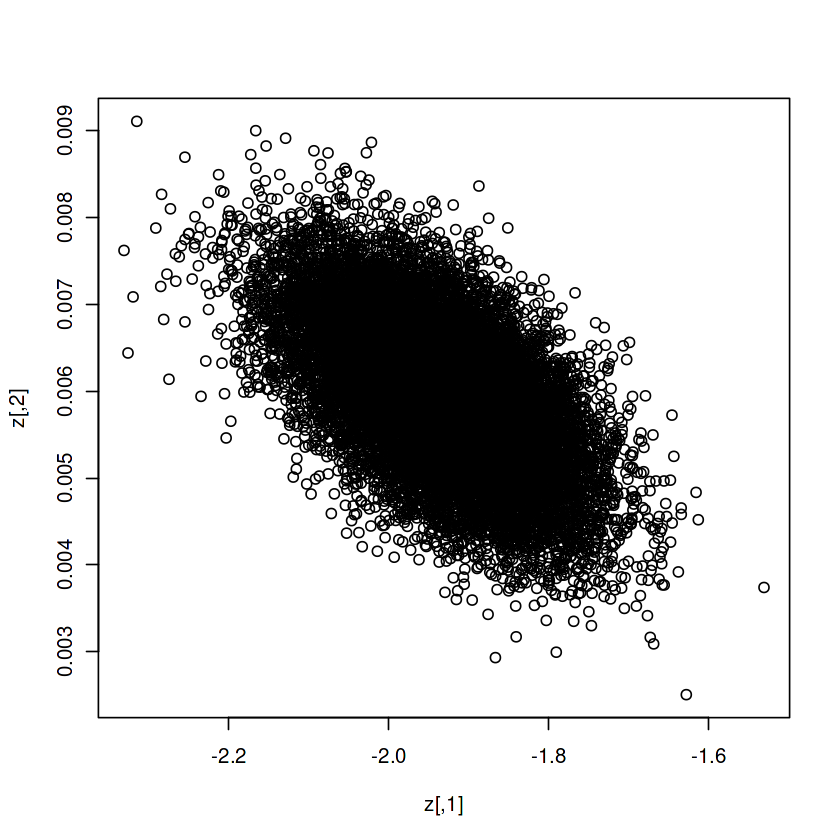

                 mean           sd         2.5%          25%          50%
beta[1]  -1.935350565 0.0924204510 -2.121707188 -1.996124629 -1.933432736
beta[2]   0.005956544 0.0007958532  0.004383965  0.005424787  0.005961157
deviance 25.214283004 2.0165505948 23.274035324 23.792707407 24.574233270
p[1]      0.026978455 0.0057174364  0.016931167  0.022960179  0.026591456
p[2]      0.028854333 0.0059002436  0.018416855  0.024739380  0.028488413
p[3]      0.039978976 0.0069385173  0.027403402  0.035161127  0.039629057
p[4]      0.068858723 0.0100276400  0.050432116  0.061964181  0.068407370
p[5]      0.149951395 0.0233532415  0.107214758  0.133869054  0.149033954
p[6]      0.329862337 0.0587045591  0.219096808  0.289715490  0.328833799
yf1[1]   10.540333333 3.9053522375  4.000000000  8.000000000 10.000000000
yf1[2]    5.882611111 2.6824341426  1.000000000  4.000000000  6.000000000
yf1[3]    6.254777778 2.6959110710  2.000000000  4.000000000  6.000000000
yf1[4]    3.426111111 1.8249666402  0.

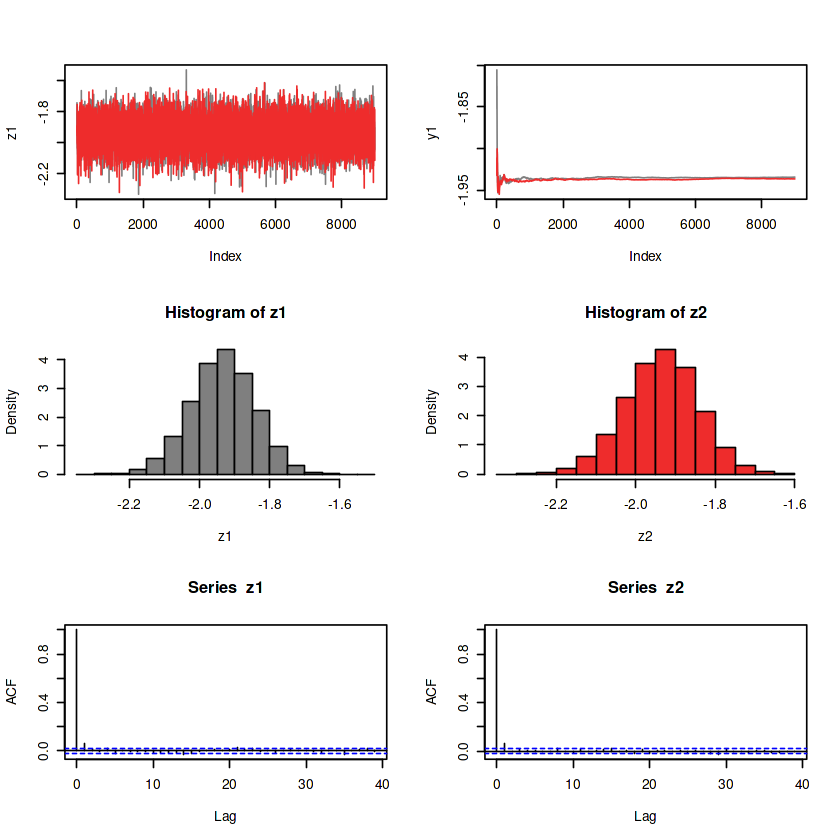

In [11]:
ej5b.sim2$viewSpace()

ej5b.sim2$graphConvergence()

ej5b.sim2$summaryModel()

ej5b.sim2$dicModelfunc()


## Checamos intervalos de predicción

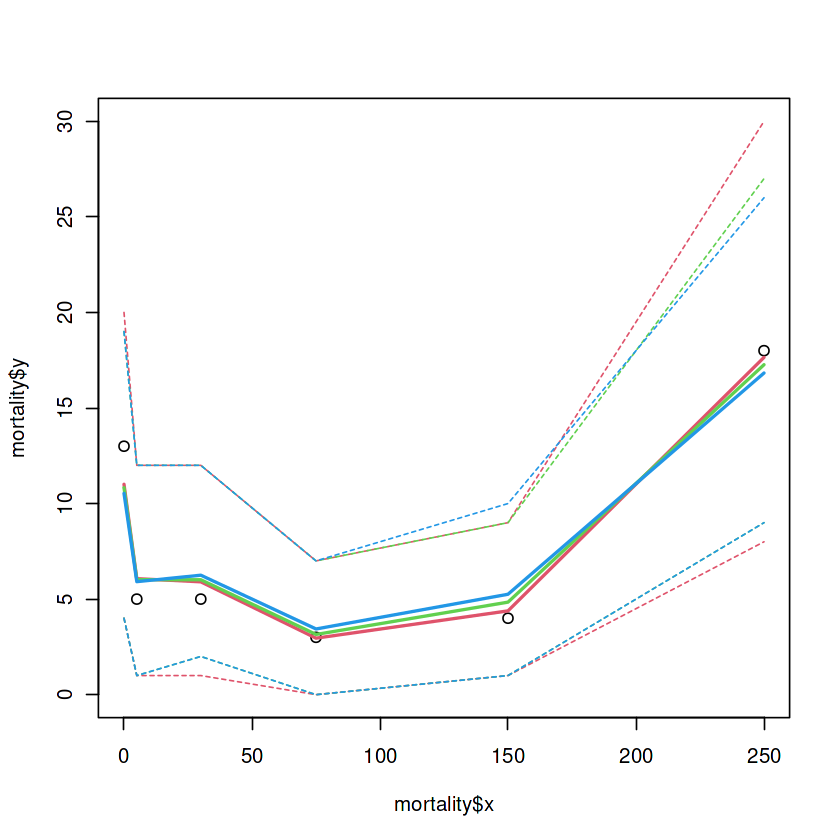

In [206]:
canvaMortalidad()

mortalidadGraf(ej5a.sim,col=2)

mortalidadGraf(ej5b.sim,col=3)

mortalidadGraf(ej5b.sim2,col=4)

## Cuarto modelo (log-log)

CHECAR

Modelo

$y_{i}|\mu_{i} \sim \text{Bin}(\text{n}_{i},\text{p}_{i})$

Relación

$\mu_{i}=\text{n}_{i}\text{p}_{i}$

Liga logística

$\text{logit}(\text{p}_{i})=\beta_{1}+\beta_{2}*x_{i}$

Priors

$\beta_{j} \sim \text{Norm}(0,0.001)$

In [13]:
#corremos código
modelCode4 <- 'model
{
#Likelihood
for (i in 1:n) {
	y[i] ~ dbin(p[i],ne[i])
	mu[i]<-ne[i]*p[i]
#Liga logistica
#	logit(p[i])<-beta[1]+beta[2]*x[i]
#	eta[i]<-beta[1]+beta[2]*x[i]
#	p[i]<-exp(eta[i])/(1+exp(eta[i]))
#Liga probit
#	p[i]<-phi(beta[1]+beta[2]*x[i])
#Liga log-log
	eta[i]<-beta[1]+beta[2]*x[i]
	p[i]<-exp(-exp(eta[i]))
#Liga clog-log
#	cloglog(p[i])<-beta[1]+beta[2]*x[i]
	}
#Priors 
for (j in 1:2) { beta[j] ~ dnorm(0,0.001) }
#Prediction 1
for (i in 1:n) { yf1[i] ~ dbin(p[i],ne[i]) }
#Prediction 2
#for (i in 1:m) { 
#	yf2[i] ~ dbin(pf[i],nef[i]) 
#	muf[i]<-nef[i]*pf[i]
#	logit(pf[i])<-beta[1]+beta[2]*xf[i]
#}
	yf2 ~ dbin(pf,nef) 
	muf<-nef*pf
#	logit(pf)<-beta[1]+beta[2]*xf
#	pf<-phi(beta[1]+beta[2]*xf)
#	etaf<-beta[1]+beta[2]*xf
#	pf<-exp(-exp(etaf))
	cloglog(pf)<-beta[1]+beta[2]*xf	
}'


ej5b.sim3 <- jagsModel$new(data, inits, parsbc, modelCode4, n.thin=5, n.iter=50000, n.burnin=5000)

ej5b.sim3$runJagsModel()



Warning message in jags.model(model.file, data = data, inits = init.values, n.chains = n.chains, :
“Unused variable "m" in data”


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 6
   Unobserved stochastic nodes: 9
   Total graph size: 72

Initializing model



## Checamos convergencia

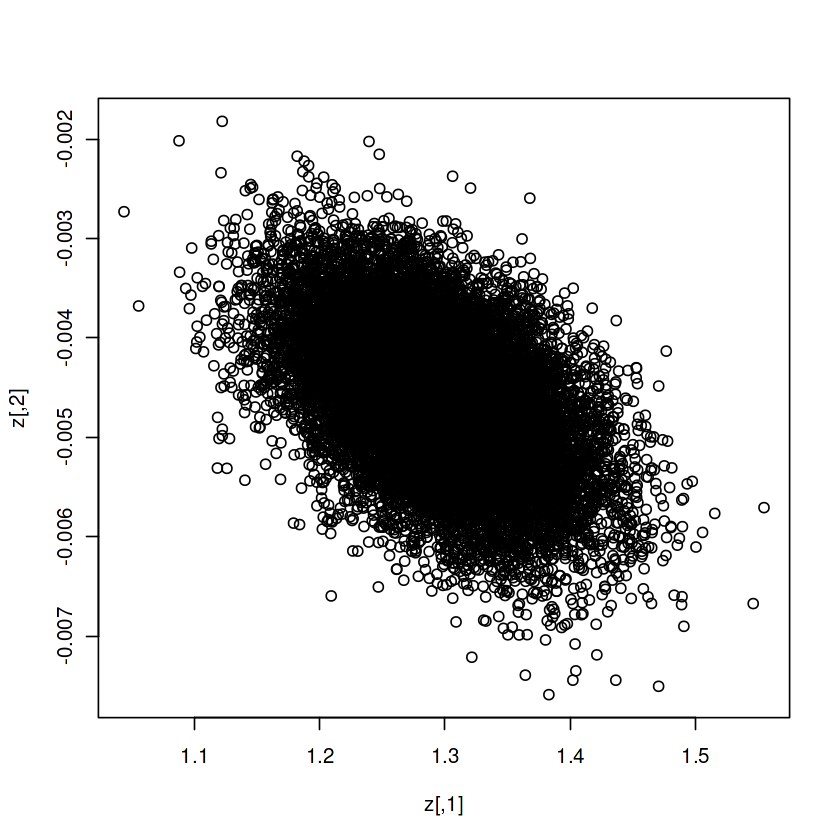

                 mean           sd         2.5%          25%          50%
beta[1]   1.293870091 0.0600293876  1.176715842  1.253300872  1.294044805
beta[2]  -0.004618118 0.0006980537 -0.006012079 -0.005086914 -0.004604272
deviance 26.032269453 2.0050751571 24.087302834 24.608798360 25.430072451
p[1]      0.026524817 0.0057737734  0.016502036  0.022436557  0.026055921
p[2]      0.028776081 0.0059561732  0.018332682  0.024562517  0.028338084
p[3]      0.042196032 0.0070692615  0.029418249  0.037238908  0.041740893
p[4]      0.076330871 0.0111999662  0.055855994  0.068433331  0.075762704
p[5]      0.162354739 0.0269542006  0.112809875  0.143448479  0.161199790
p[6]      0.317434642 0.0554800657  0.211912279  0.279161153  0.316086606
yf1[1]   10.401722222 3.9548267785  4.000000000  8.000000000 10.000000000
yf1[2]    5.893888889 2.6913500448  1.000000000  4.000000000  6.000000000
yf1[3]    6.572055556 2.7392420626  2.000000000  5.000000000  6.000000000
yf1[4]    3.789222222 1.9455375468  1.

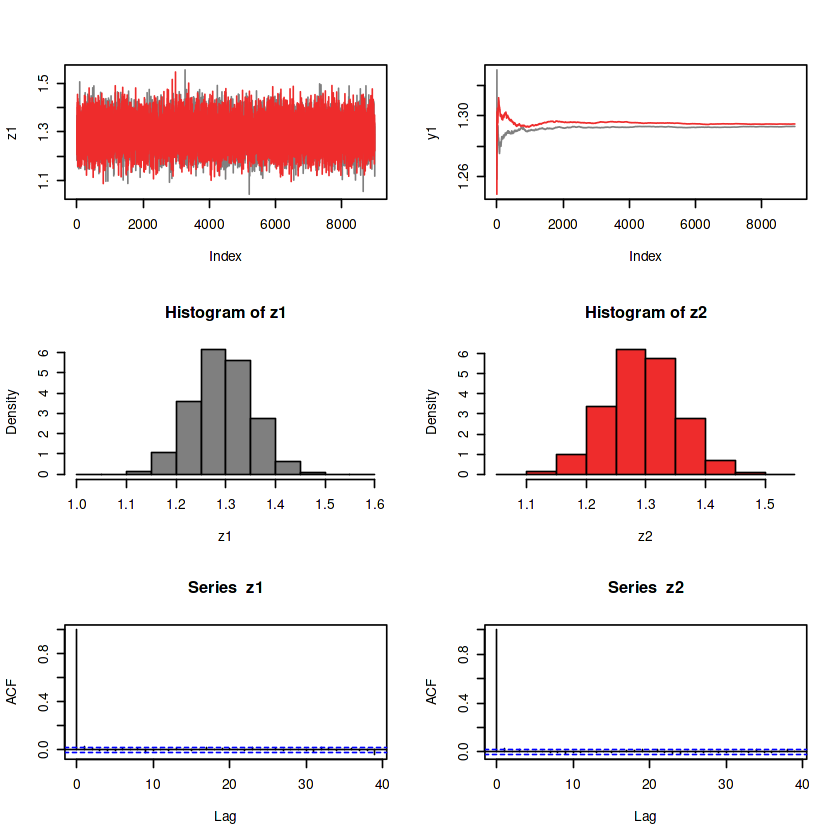

In [14]:
ej5b.sim3$viewSpace()

ej5b.sim3$graphConvergence()

ej5b.sim3$summaryModel()

ej5b.sim3$dicModelfunc()


## Checamos intervalos de predicción

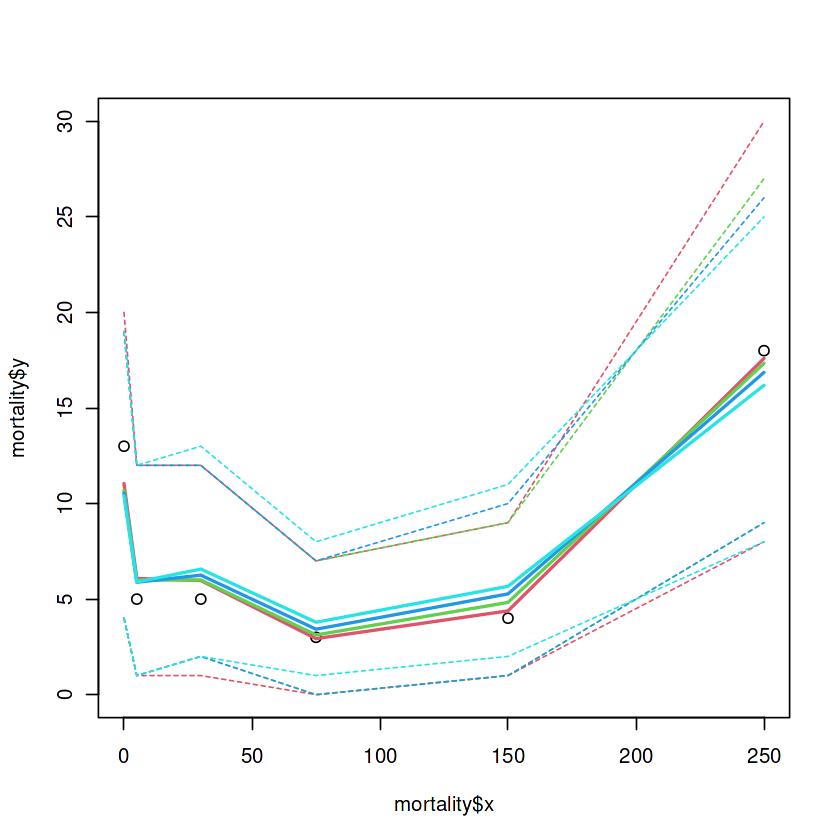

In [15]:
canvaMortalidad()

mortalidadGraf(ej5a.sim,col=2)

mortalidadGraf(ej5b.sim,col=3)

mortalidadGraf(ej5b.sim2,col=4)

mortalidadGraf(ej5b.sim3,col=5)

## Quinto modelo (clog-log)

CHECAR

Modelo

$y_{i}|\mu_{i} \sim \text{Bin}(\text{n}_{i},\text{p}_{i})$

Relación

$\mu_{i}=\text{n}_{i}\text{p}_{i}$

Liga logística

$\text{logit}(\text{p}_{i})=\beta_{1}+\beta_{2}*x_{i}$

Priors

$\beta_{j} \sim \text{Norm}(0,0.001)$

In [16]:
#corremos código
modelCode5 <- 'model
{
#Likelihood
for (i in 1:n) {
	y[i] ~ dbin(p[i],ne[i])
	mu[i]<-ne[i]*p[i]
#Liga logistica
#	logit(p[i])<-beta[1]+beta[2]*x[i]
#	eta[i]<-beta[1]+beta[2]*x[i]
#	p[i]<-exp(eta[i])/(1+exp(eta[i]))
#Liga probit
#	p[i]<-phi(beta[1]+beta[2]*x[i])
#Liga log-log
#	eta[i]<-beta[1]+beta[2]*x[i]
#	p[i]<-exp(-exp(eta[i]))
#Liga clog-log
	cloglog(p[i])<-beta[1]+beta[2]*x[i]
	}
#Priors 
for (j in 1:2) { beta[j] ~ dnorm(0,0.001) }
#Prediction 1
for (i in 1:n) { yf1[i] ~ dbin(p[i],ne[i]) }
#Prediction 2
#for (i in 1:m) { 
#	yf2[i] ~ dbin(pf[i],nef[i]) 
#	muf[i]<-nef[i]*pf[i]
#	logit(pf[i])<-beta[1]+beta[2]*xf[i]
#}
	yf2 ~ dbin(pf,nef) 
	muf<-nef*pf
#	logit(pf)<-beta[1]+beta[2]*xf
#	pf<-phi(beta[1]+beta[2]*xf)
#	etaf<-beta[1]+beta[2]*xf
#	pf<-exp(-exp(etaf))
	cloglog(pf)<-beta[1]+beta[2]*xf	
}'

ej5b.sim4 <- jagsModel$new(data, inits, parsbc, modelCode5, n.thin=5, n.iter=50000, n.burnin=5000)

ej5b.sim4$runJagsModel()


Warning message in jags.model(model.file, data = data, inits = init.values, n.chains = n.chains, :
“Unused variable "m" in data”


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 6
   Unobserved stochastic nodes: 9
   Total graph size: 60

Initializing model



## Checamos convergencia

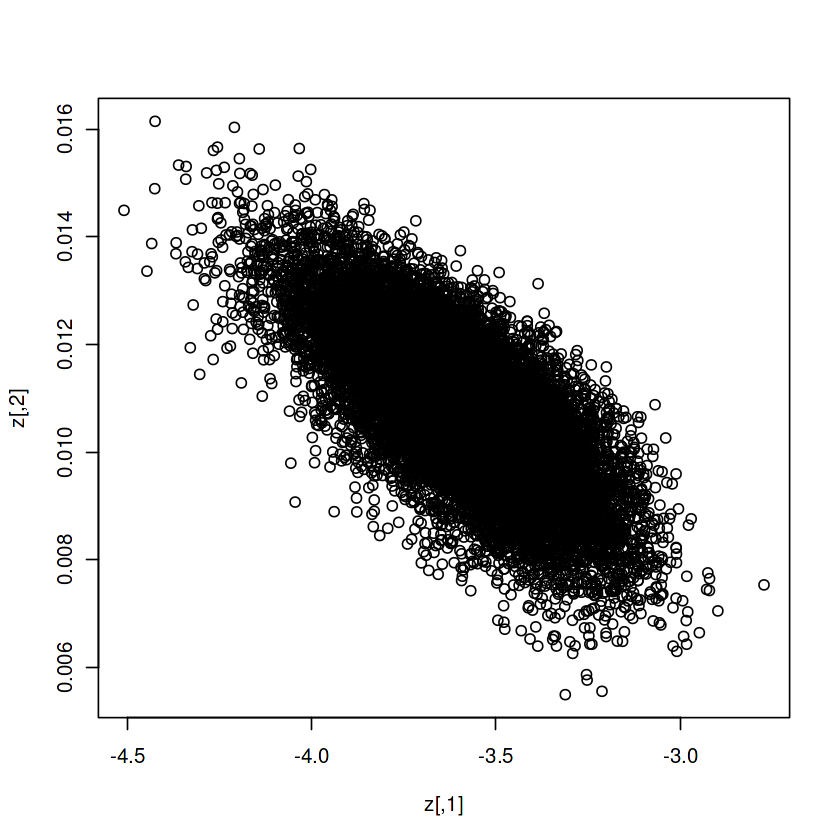

                mean          sd         2.5%          25%         50%
beta[1]  -3.58838195 0.210543598 -4.023974394 -3.725694080 -3.58006511
beta[2]   0.01078646 0.001336155  0.008152231  0.009897703  0.01077656
deviance 24.59190678 2.028517299 22.613478921 23.145496139 23.97593624
p[1]      0.02784074 0.005705156  0.017722825  0.023808370  0.02748899
p[2]      0.02933252 0.005870902  0.018884708  0.025188072  0.02898996
p[3]      0.03807862 0.006784173  0.025850447  0.033328250  0.03773696
p[4]      0.06084303 0.009067496  0.044368232  0.054579516  0.06043480
p[5]      0.13135569 0.018747783  0.097284529  0.118264738  0.13054726
p[6]      0.34061178 0.062980331  0.224750498  0.296095687  0.33789554
yf1[1]   10.90933333 3.953814365  4.000000000  8.000000000 11.00000000
yf1[2]    5.96144444 2.675115768  1.000000000  4.000000000  6.00000000
yf1[3]    5.92461111 2.607142907  2.000000000  4.000000000  6.00000000
yf1[4]    3.03544444 1.741876711  0.000000000  2.000000000  3.00000000
yf1[5]

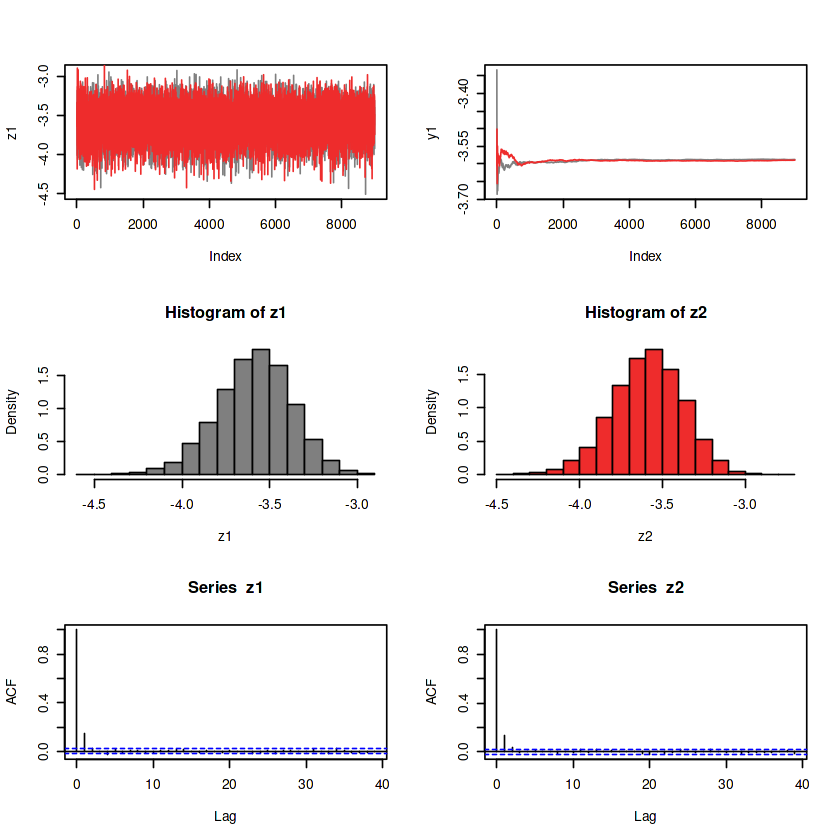

In [17]:
ej5b.sim4$viewSpace()

ej5b.sim4$graphConvergence()

ej5b.sim4$summaryModel()

ej5b.sim4$dicModelfunc()

## Checamos intervalos de predicción

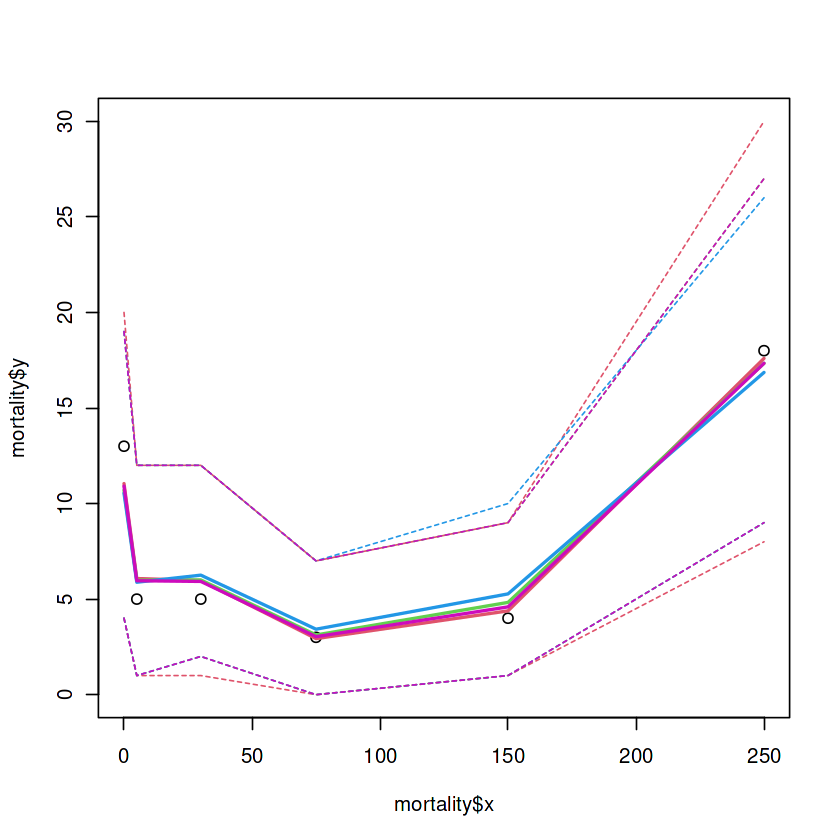

In [20]:
canvaMortalidad()

mortalidadGraf(ej5a.sim,col=2)

mortalidadGraf(ej5b.sim,col=3)

mortalidadGraf(ej5b.sim2,col=4)

mortalidadGraf(ej5b.sim4,col=6)

## Sexto modelo

CHECAR

Modelo

$y_{i}|\mu_{i} \sim \text{Bin}(\text{n}_{i},\text{p}_{i})$

Relación

$\mu_{i}=\text{n}_{i}\text{p}_{i}$

Liga logística

$\text{logit}(\text{p}_{i})=\beta_{1}+\beta_{2}*x_{i}$

Priors

$\beta_{j} \sim \text{Norm}(0,0.001)$

In [21]:
#corremos código
modelCode6 <- 'model
{
#Likelihood
for (i in 1:n) {
	y[i] ~ dnegbin(p[i],ne[i])
	mu[i]<-ne[i]*lambda[i]
	lambda[i]<-(1-p[i])/p[i]
	eta[i]<-beta[1]+beta[2]*x[i]
#	logit(1-p[i])<-eta[i]
	p[i]<-1/(1+exp(eta[i]))
	}
#Priors 
for (j in 1:2) { beta[j] ~ dnorm(0,0.001) }
#Prediction 1
for (i in 1:n) { yf1[i] ~ dnegbin(p[i],ne[i]) }
#Prediction 2
#for (i in 1:m) { 
#	yf2[i] ~ dnegbin(pf[i],nef[i]) 
#	etaf[i]<-beta[1]+beta[2]*xf[i]
#	pf[i]<-1/(1+exp(etaf[i])
#}
	yf2 ~ dnegbin(pf,nef) 
	etaf<-beta[1]+beta[2]*xf
	pf<-1/(1+exp(etaf))
}'

ej5c.sim <- jagsModel$new(data, inits, parsbc, modelCode6, n.thin=5, n.iter=50000, n.burnin=5000)

ej5c.sim$runJagsModel()


Warning message in jags.model(model.file, data = data, inits = init.values, n.chains = n.chains, :
“Unused variable "m" in data”


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 6
   Unobserved stochastic nodes: 9
   Total graph size: 86

Initializing model



## Checamos convergencia

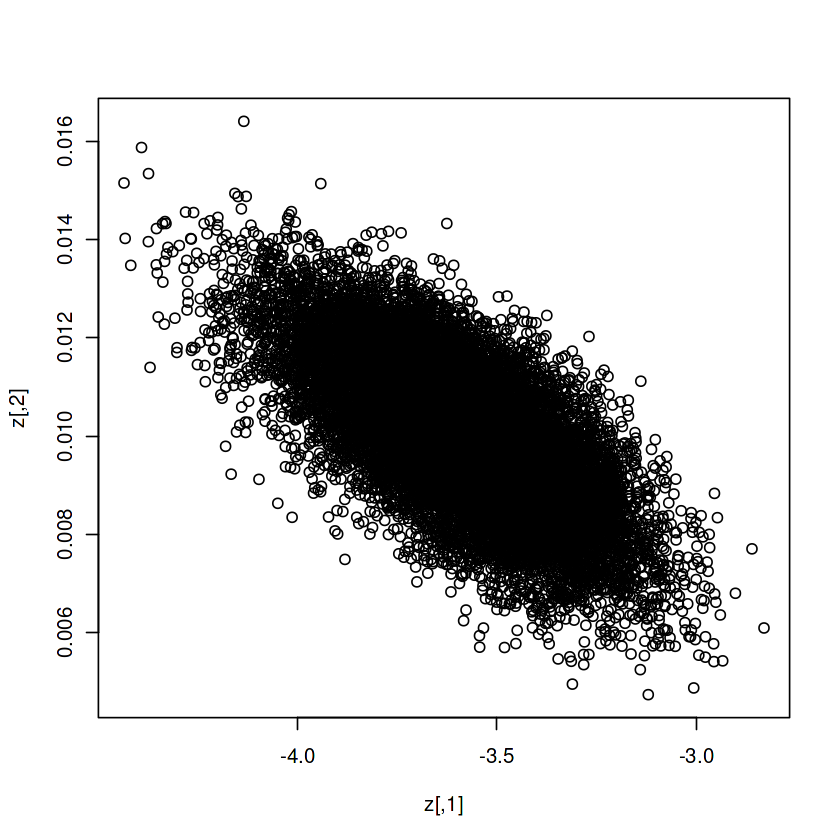

                mean          sd         2.5%          25%         50%
beta[1]  -3.58931188 0.212528195 -4.026540576 -3.728281171 -3.58418155
beta[2]   0.01003908 0.001425206  0.007252184  0.009082126  0.01003439
deviance 25.64196000 1.982244295 23.704034491 24.225605164 25.03594656
p[1]      0.97256820 0.005616722  0.960629989  0.969013533  0.97299039
p[2]      0.97122473 0.005748604  0.959072190  0.967574930  0.97164614
p[3]      0.96346691 0.006473676  0.949826697  0.959322546  0.96386011
p[4]      0.94402200 0.008357209  0.926735902  0.938601552  0.94441139
p[5]      0.88819644 0.016691707  0.853165577  0.877416984  0.88906392
p[6]      0.74328825 0.049100384  0.640953840  0.710910400  0.74584106
yf1[1]   11.05738889 4.104567678  4.000000000  8.000000000 11.00000000
yf1[2]    6.06427778 2.806901310  1.000000000  4.000000000  6.00000000
yf1[3]    5.94711111 2.733608954  1.000000000  4.000000000  6.00000000
yf1[4]    2.96238889 1.826789449  0.000000000  2.000000000  3.00000000
yf1[5]

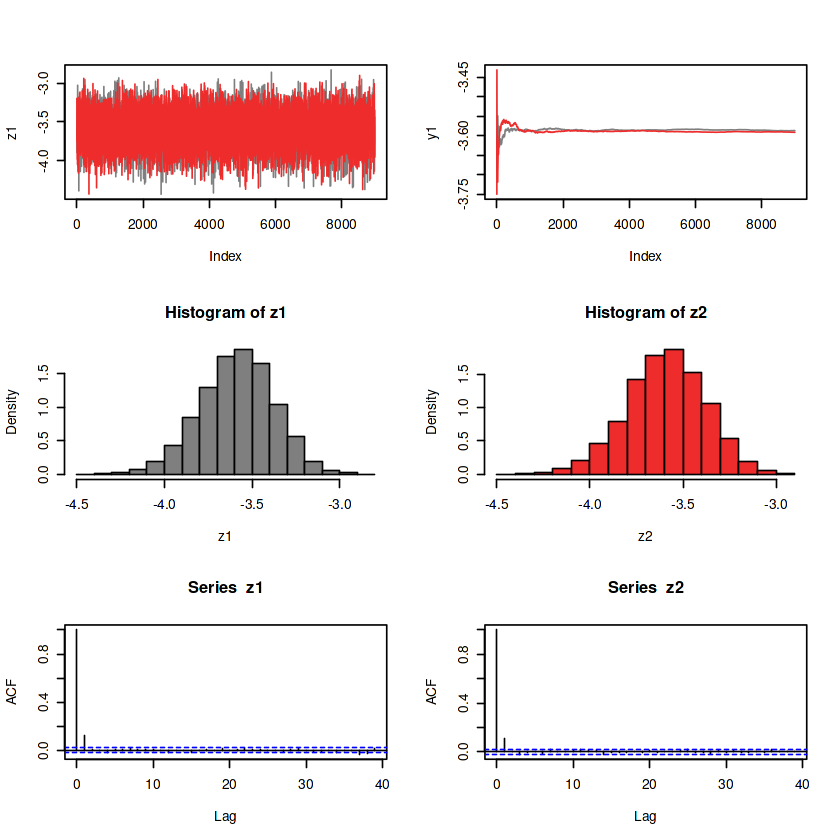

In [22]:
ej5c.sim$viewSpace()

ej5c.sim$graphConvergence()

ej5c.sim$summaryModel()

ej5c.sim$dicModelfunc()

## Checamos intervalos de predicción

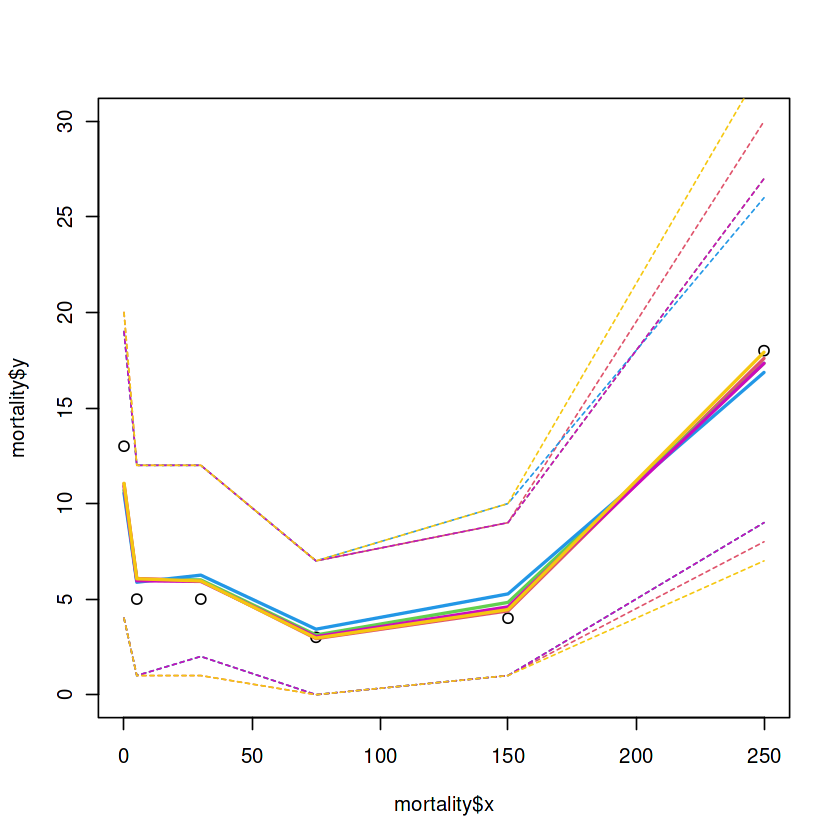

In [23]:
canvaMortalidad()

mortalidadGraf(ej5a.sim,col=2)

mortalidadGraf(ej5b.sim,col=3)

mortalidadGraf(ej5b.sim2,col=4)

mortalidadGraf(ej5b.sim4,col=6)

mortalidadGraf(ej5c.sim,col=7)

## Séptimo modelo

CHECAR

Modelo

$y_{i}|\mu_{i} \sim \text{Bin}(\text{n}_{i},\text{p}_{i})$

Relación

$\mu_{i}=\text{n}_{i}\text{p}_{i}$

Liga logística

$\text{logit}(\text{p}_{i})=\beta_{1}+\beta_{2}*x_{i}$

Priors

$\beta_{j} \sim \text{Norm}(0,0.001)$

In [24]:
#corremos código
modelCode7 <- 'model
{
#Likelihood
for (i in 1:n) {
	y[i] ~ dbeta(a[i],b[i])
	a[i]<-phy*mu[i]
	b[i]<-phy*(1-mu[i])
#	logit(mu[i])<-beta[1]+beta[2]*x[i]
	eta[i]<-beta[1]+beta[2]*x[i]
	mu[i]<-exp(eta[i])/(1+exp(eta[i]))
	}
#Priors 
phy ~ dgamma(0.01,0.01)
for (j in 1:2) { beta[j] ~ dnorm(0,0.001) }
#Prediction 1
for (i in 1:n) { yf1[i] ~ dbeta(a[i],b[i]) }
#Prediction 2
	yf2 ~ dbeta(af,bf) 
	af<-phy*muf
	bf<-phy*(1-muf)
	logit(muf)<-beta[1]+beta[2]*xf
}'

ej5d.sim <- jagsModel$new(data2, inits2, parsd, modelCode7, n.thin=10, n.iter=50000, n.burnin=5000)

ej5d.sim$runJagsModel()

Warning message in jags.model(model.file, data = data, inits = init.values, n.chains = n.chains, :
“Unused variable "m" in data”


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 6
   Unobserved stochastic nodes: 10
   Total graph size: 82

Initializing model



## Checamos convergencia

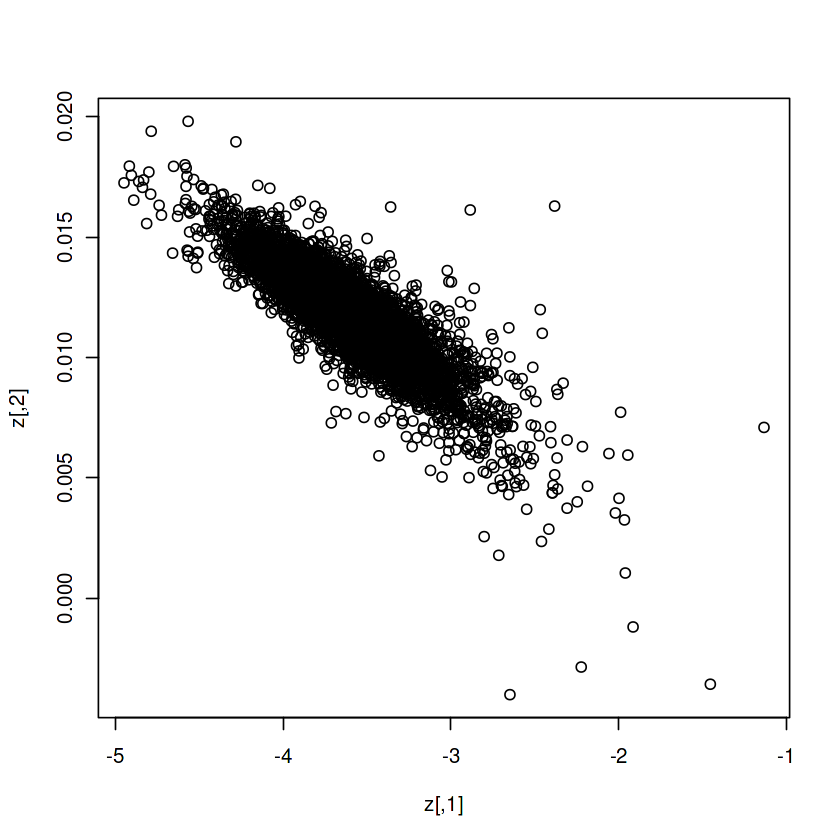

                 mean           sd          2.5%          25%          50%
beta[1]   -3.61215007 3.068716e-01  -4.197732866  -3.79800846  -3.62253419
beta[2]    0.01178176 1.676481e-03   0.008173615   0.01089869   0.01186523
deviance -31.78276722 4.345399e+00 -38.308650707 -34.97402754 -32.41349668
phy      154.48111615 1.052557e+02  22.313295484  76.96899630 131.17275764
yf1[1]     0.02765090 2.136656e-02   0.002892215   0.01474369   0.02347038
yf1[2]     0.02935034 2.389802e-02   0.002898732   0.01593476   0.02501312
yf1[3]     0.03838617 2.698539e-02   0.007055198   0.02357233   0.03423396
yf1[4]     0.06275750 3.033385e-02   0.019078289   0.04440570   0.05880100
yf1[5]     0.13732671 4.511049e-02   0.065551781   0.11183222   0.13355309
yf1[6]     0.33968412 6.945188e-02   0.202447772   0.30099494   0.33823697
yf2        0.22321729 5.250908e-02   0.125239097   0.19255593   0.22008698
                  75%        97.5%     Rhat n.eff
beta[1]   -3.44452593  -2.94954041 1.001711  5800


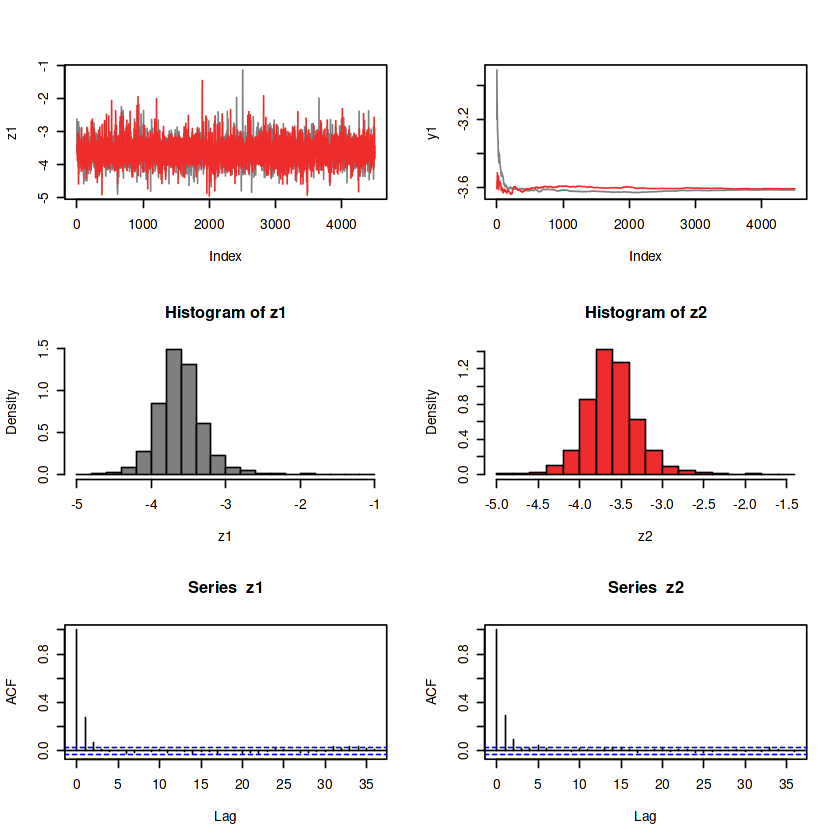

In [25]:
ej5d.sim$viewSpace()

ej5d.sim$graphConvergence()

ej5d.sim$summaryModel()

ej5d.sim$dicModelfunc()

## Checamos intervalos de predicción

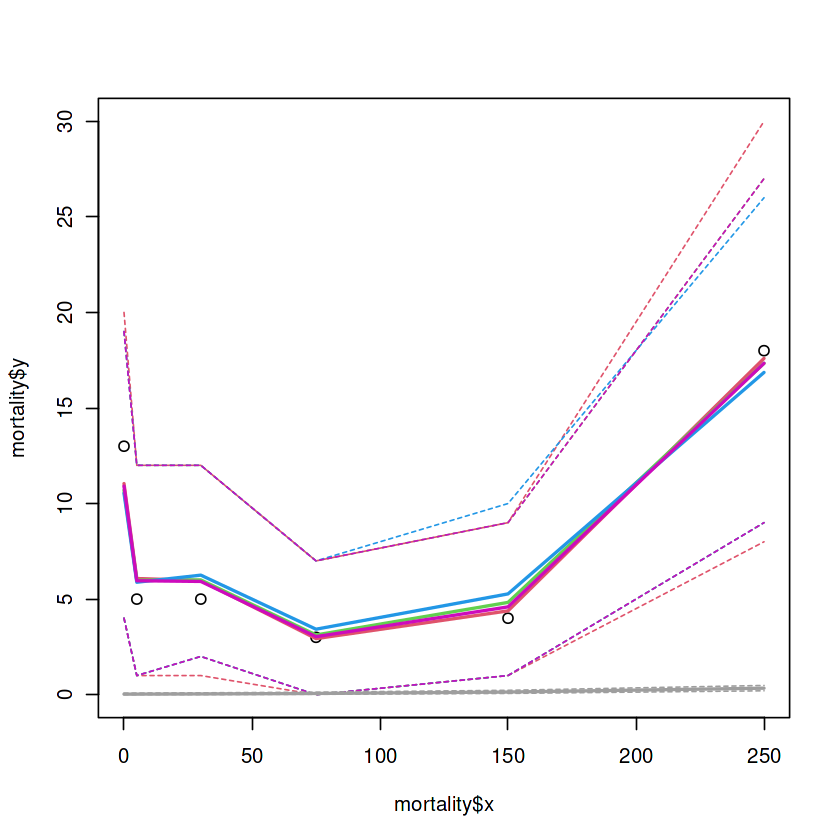

In [26]:
canvaMortalidad()

mortalidadGraf(ej5a.sim,col=2)

mortalidadGraf(ej5b.sim,col=3)

mortalidadGraf(ej5b.sim2,col=4)


mortalidadGraf(ej5b.sim4,col=6)


mortalidadGraf(ej5d.sim,col=8)